In [ ]:
# @title Utilities: Touchstone parser + Parallel-RLC estimator
import numpy as np
import re

def parse_s1p(path):
    """
    Parse a 1-port Touchstone (.s1p).
    Supports header like: '# Hz S DB R 50' (units: Hz/kHz/MHz/GHz; formats: DB/MA/RI).
    Returns: freq_Hz (np.array), S11 (complex np.array), Z0 (float), meta (dict).
    """
    unit_scale = {"hz":1.0, "khz":1e3, "mhz":1e6, "ghz":1e9}
    scale = 1.0
    fmt = None
    z0 = 50.0

    freqs, c1, c2 = [], [], []
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        for raw in f:
            line = raw.strip()
            if not line or line.startswith("!"):
                continue
            if line.startswith("#"):
                tokens = line[1:].strip().lower().split()
                if tokens and tokens[0] in unit_scale:
                    scale = unit_scale[tokens[0]]
                if "s" in tokens:  # format (DB/MA/RI)
                    i = tokens.index("s")
                    if i+1 < len(tokens):
                        fmt = tokens[i+1]
                if "r" in tokens:  # reference impedance
                    i = tokens.index("r")
                    if i+1 < len(tokens):
                        try: z0 = float(tokens[i+1])
                        except: pass
                continue
            parts = re.split(r"[\s,]+", line)
            if len(parts) < 3:
                continue
            try:
                fval = float(parts[0]) * scale
                v1 = float(parts[1]); v2 = float(parts[2])
            except:
                continue
            freqs.append(fval); c1.append(v1); c2.append(v2)

    freqs = np.asarray(freqs, float)
    c1 = np.asarray(c1, float)
    c2 = np.asarray(c2, float)

    if fmt is None:
        fmt = "db"  # default

    fmt = fmt.lower()
    if fmt == "db":
        mag = 10**(c1/20.0); ang = np.deg2rad(c2)
        s11 = mag * np.exp(1j*ang)
    elif fmt == "ma":
        mag = c1; ang = np.deg2rad(c2)
        s11 = mag * np.exp(1j*ang)
    elif fmt == "ri":
        s11 = c1 + 1j*c2
    else:
        mag = 10**(c1/20.0); ang = np.deg2rad(c2)
        s11 = mag * np.exp(1j*ang)

    meta = {"format": fmt.upper(), "z0": z0}
    return freqs, s11, z0, meta


def estimate_parallel_rlc(freq, Z, min_points=8, verbose=True):
    """
    Fit a single parallel RLC (Rp || L || C) from one-port impedance data.
    Steps
      1) f0: zero crossing of Im(Z) nearest the peak of Re(Z) (interpolated).
      2) Rp = Re(Z) at f0 (interpolated).
      3) L: robust average of Im(Z)/(2*pi*f) in inductive region below f0 where |Im(Z)| >> Re(Z).
      4) C = 1/( (2*pi*f0)^2 * L ).
      5) Q = Rp/(omega0 * L).
    Returns dict with f0, Rp, L, C, Q, and some diagnostics.
    """
    ReZ = np.real(Z); ImZ = np.imag(Z)
    n = len(freq)

    # --- Find resonance f0: pick Im(Z)=0 crossing closest to max Re(Z)
    idx_max = int(np.argmax(ReZ))
    sign = np.sign(ImZ); sign[sign==0] = 1
    xc = np.where(np.diff(sign) != 0)[0]

    if xc.size == 0:
        # Fallback: absolute min of |ImZ|
        idx0 = int(np.argmin(np.abs(ImZ)))
        f0 = freq[idx0]
        Rp = ReZ[idx0]
    else:
        idxc = xc[np.argmin(np.abs(xc - idx_max))]
        f1, f2 = freq[idxc], freq[idxc+1]
        y1, y2 = ImZ[idxc], ImZ[idxc+1]
        # Linear interpolation for ImZ=0
        f0 = f1 if y2 == y1 else f1 - y1*(f2 - f1)/(y2 - y1)
        # Interpolate ReZ at f0
        r1, r2 = ReZ[idxc], ReZ[idxc+1]
        Rp = r1 + (r2 - r1) * (f0 - f1) / (f2 - f1)

    omega0 = 2*np.pi*f0

    # --- Inductive band below f0 (relatively small resistive loading)
    mask = (freq < 0.85*f0) & (ImZ > 0) & (ReZ < 0.15*Rp)
    # Require |ImZ| dominance; relax if too strict
    good = mask & (np.abs(ImZ) > 5*np.maximum(np.abs(ReZ), 1e-12))
    if np.count_nonzero(good) < min_points:
        good = (freq < 0.9*f0) & (ImZ > 0)
    L_pts = ImZ[good] / (2*np.pi*freq[good])

    if L_pts.size == 0:
        raise RuntimeError("No suitable low-frequency inductive points found. Extend sweep lower or reduce loss.")

    # Robust average via MAD
    med = np.median(L_pts)
    mad = 1.4826*np.median(np.abs(L_pts - med)) if L_pts.size > 4 else 0.0
    if mad > 0:
        keep = np.abs(L_pts - med) < 3*mad
        L_used = L_pts[keep]
    else:
        L_used = L_pts
    L = float(np.mean(L_used))
    C = float(1.0 / (omega0**2 * L))
    Q = float(Rp / (omega0 * L))

    if verbose:
        print(f"f0  = {f0/1e6:.6f} MHz")
        print(f"Rp  = {Rp:.3f} Ω")
        print(f"L   = {L*1e6:.3f} µH")
        print(f"C   = {C*1e12:.3f} pF")
        print(f"Q   = {Q:.3f}")
        print(f"Points used for L: {L_used.size}")

    return {"f0_Hz": float(f0), "Rp_Ohm": float(Rp), "L_H": float(L), "C_F": float(C),
            "Q": float(Q), "n_points_L": int(L_used.size)}


In [ ]:
# @title Upload a .s1p file
from google.colab import files
uploaded = files.upload()  # choose your .s1p
s1p_path = next(iter(uploaded))  # first (or only) file name
print("Loaded:", s1p_path)


Saving NEW_COIL.s1p to NEW_COIL.s1p
Loaded: NEW_COIL.s1p


In [ ]:
# @title Compute parallel RLC from the uploaded file
freq, s11, z0, meta = parse_s1p(s1p_path)
Z = z0 * (1 + s11) / (1 - s11)

print(f"Header: Z0={meta['z0']} Ω, Format={meta['format']}")
est = estimate_parallel_rlc(freq, Z, verbose=True)

# Optional: save a CSV summary
import csv
summary_path = "parallel_rlc_summary.csv"
with open(summary_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["Quantity", "Value (SI)"])
    w.writerow(["f0_Hz", est["f0_Hz"]])
    w.writerow(["Rp_Ohm", est["Rp_Ohm"]])
    w.writerow(["L_H", est["L_H"]])
    w.writerow(["C_F", est["C_F"]])
    w.writerow(["Q", est["Q"]])
print("Saved:", summary_path)


Header: Z0=50.0 Ω, Format=DB
f0  = 2.384143 MHz
Rp  = 9048.407 Ω
L   = 58.180 µH
C   = 76.595 pF
Q   = 10.382
Points used for L: 27
Saved: parallel_rlc_summary.csv


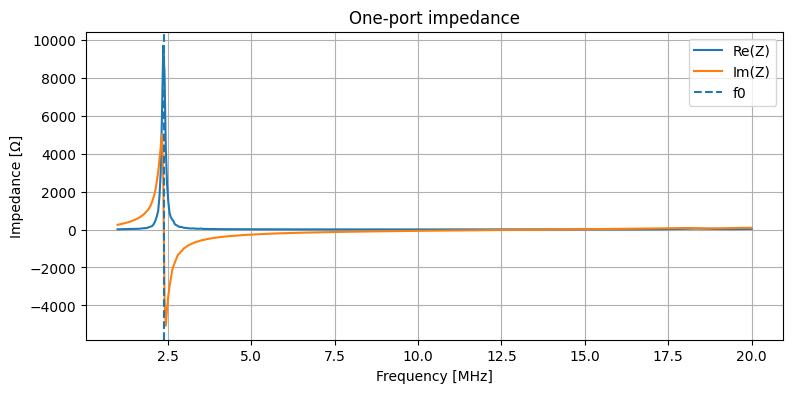

In [ ]:
# @title Plot Re(Z) and Im(Z) vs frequency
import matplotlib.pyplot as plt
ReZ = np.real(Z); ImZ = np.imag(Z)

plt.figure(figsize=(9,4))
plt.plot(freq/1e6, ReZ, label="Re(Z)")
plt.plot(freq/1e6, ImZ, label="Im(Z)")
plt.axvline(est["f0_Hz"]/1e6, linestyle="--", label="f0")
plt.xlabel("Frequency [MHz]"); plt.ylabel("Impedance [Ω]"); plt.title("One-port impedance")
plt.legend(); plt.grid(True); plt.show()


In [ ]:
# @title Export a simple parallel-RLC SPICE subcircuit
name = "coil_port_parallel_rlc"
f0 = est["f0_Hz"]; Rp = est["Rp_Ohm"]; L = est["L_H"]; C = est["C_F"]

subckt = f""".subckt {name} 1 0
Rp 1 0 {Rp:.6g}
L1 1 0 {L:.6g}
C1 1 0 {C:.6g}
.ends {name}
"""
with open(f"{name}.sub", "w") as f:
    f.write(subckt)

print(subckt)
